# Testing Notebook

This notebook tests the active learning functionality of the developed GP package. In particular, we will train a GP model adaptively to capture the failure boundary (limit-state)

In [1]:
# Get path right
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\GaussianProcess")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Import GP interpolation module
from GPInterpolator import GPInterpolator

%matplotlib inline

# 1. Test Function (1D)

We select the following test function in this case study:

\begin{equation}
y(x_1, x_2) = 20-(x_1-x_2)^2-8(x_1+x_2-4)^3, \; x_1 \in [-6, 6], x_2 \in [-4, 6]
\end{equation}

The failure boundary is defined as $y(x_1, x_2) = 0$.

Later on, we will train a Gaussian Process model to capture the failure boundary. This is crucial for accurate and robust risk analysis. To minimize the number of employed training samples, we will use an active learning strategy to allocate new samples in the vicinity of the failure boundary. 

For now, let's first plot this function to gain some intuition.

In [2]:
def Test_2D(X):
    """2D Test Function"""
    y = 20 - (X[:,0]-X[:,1])**2 - 8*(X[:,0]+X[:,1]-4)**3
    return y

In [4]:
# Load LHS package
from pyDOE import lhs

# Training data
sample_num = 13
lb, ub = np.array([-6, -4]), np.array([6, 6])
X_train = (ub-lb)*lhs(2, samples=sample_num) + lb

# Compute labels
y_train = Test_2D(X_train).reshape(-1,1)

# Test data
X1 = np.linspace(-6, 6, 100)
X2 = np.linspace(-4, 6, 100)
X1, X2 = np.meshgrid(X1, X2)
X_test = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1)))
y_test = Test_2D(X_test)

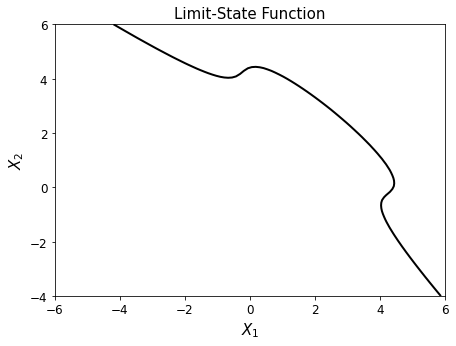

In [15]:
fig, ax = plt.subplots(figsize=(7,5))
ax.contour(X_test[:,0].reshape(100,-1), 
               X_test[:,1].reshape(100,-1), 
               y_test.reshape(100,-1), levels = [0],
                 colors='k',linestyles='-',linewidths=2)
ax.set_xlabel(r'$X_1$', fontsize=15)
ax.set_ylabel(r'$X_2$', fontsize=15)
ax.set_title('Limit-State Function', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12);

In [80]:
# GP model training
pipe = Pipeline([('scaler', MinMaxScaler()), 
         ('GP', GPInterpolator(n_restarts=30))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('GP',
                 <GPInterpolator.GPInterpolator object at 0x000001FF259BE1C0>)])

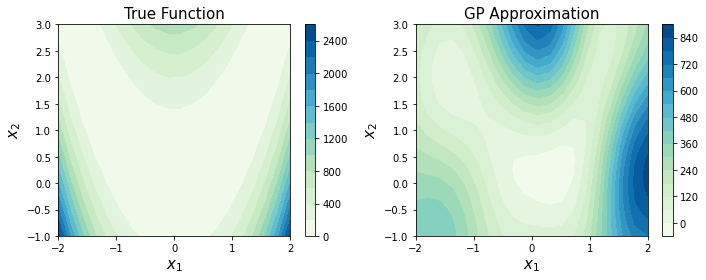

In [81]:
# GP model predicting
y_pred, y_pred_SSqr = pipe.predict(X_test)

# Post-processing - Contour plot
fig, ax = plt.subplots(1, 2, figsize=(10,4))
title = ['True Function', 'GP Approximation']
display_y = [y_test, y_pred]

for i in range(2):
    h = ax[i].contourf(X_test[:,0].reshape(20,-1), 
                   X_test[:,1].reshape(20,-1), 
                   display_y[i].reshape(20,-1), levels=15, cmap='GnBu');
    ax[i].set_xlabel(r'$x_1$', fontsize=15)
    ax[i].set_ylabel(r'$x_2$', fontsize=15)
    ax[i].set_title(title[i], fontsize=15)
    fig.colorbar(h, ax=ax[i])
plt.tight_layout()

In [82]:
# Start active learning
iteration = 1
EPE_history = []

# Generate candidate samples
X1 = np.linspace(-2, 2, 100)
X2 = np.linspace(-1, 3, 100)
X1, X2 = np.meshgrid(X1, X2)
Candidate = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1)))
Candidate_normalized = pipe['scaler'].transform(Candidate)

**The following two cells can be excuted multiple times to manually control the iteration flow**. The first cell identify the sample with the maximum prediction error. The second and third cell visually summarizes the results from the current iteration and add newly identified samples to the current training dataset.

In [95]:
# 1-GP model training and predicting
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)[0]
rmse_score = pipe.score(X_test, y_test)

# 2-Active learning
target, index, EPE = pipe['GP'].enrichment('EPE', 
                                     candidate=Candidate_normalized, 
                                     diagnose=True)
EPE_history.append(target)

# 3-Display iteration info
summary = 'Iteration summary:'
iter_number = 'Current iteration: {}'.format(str(iteration))

Iteration_summary = 'Iteration {}:'.format(str(iteration)) \
                    + os.linesep \
                    + 'Current max EPE is {}'.format(str(target)) \
                    + os.linesep \
                    + 'Located at {}'.format(str(Candidate[index])) \
                    + os.linesep \
                    + 'Current MSE is {}'.format(str(rmse_score))

print(Iteration_summary)

Iteration 7:
Current max EPE is 942.3086945402854
Located at [ 1.03030303 -1.        ]
Current MSE is 1.2434779699993703


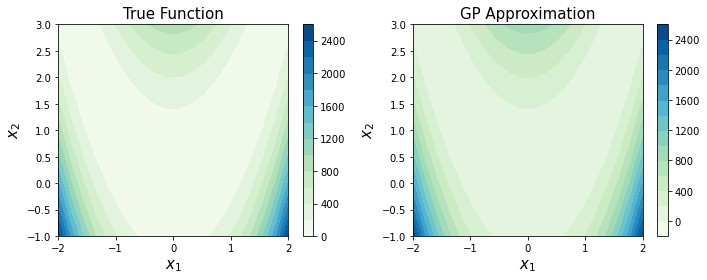

In [96]:
# 4-Iteration assessment
fig, ax = plt.subplots(1, 2, figsize=(10,4))
title = ['True Function', 'GP Approximation']
display_y = [y_test, y_pred]

for i in range(2):
    h = ax[i].contourf(X_test[:,0].reshape(20,-1), 
                   X_test[:,1].reshape(20,-1), 
                   display_y[i].reshape(20,-1), levels=15, cmap='GnBu');
    ax[i].set_xlabel(r'$x_1$', fontsize=15)
    ax[i].set_ylabel(r'$x_2$', fontsize=15)
    ax[i].set_title(title[i], fontsize=15)
    fig.colorbar(h, ax=ax[i])
plt.tight_layout()

# 5-Enrich training dataset
X_train = np.vstack((X_train, Candidate[[index],:]))
y_train = np.vstack((y_train, Test_2D(Candidate[[index],:]).reshape(-1,1)))
iteration += 1

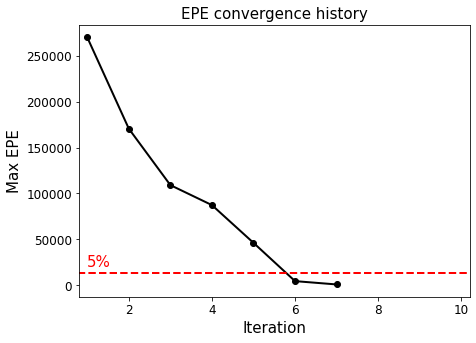

In [97]:
# EPE convergence history
fig, ax = plt.subplots(figsize=(7,5))

ax.plot(np.arange(1,iteration), EPE_history, 'k-o', lw=2)
ax.plot([0,15.3],[EPE_history[0]*0.05, EPE_history[0]*0.05],'r--',lw=2)
ax.text(1,20000,'5%',fontsize=15, color='r')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel('Max EPE', fontsize=15)
ax.set_title('EPE convergence history', fontsize=15)
ax.set_xlim([0.8, 10.2]);